# **CONVOLUTIONAL NEURAL NETWORK (CNN)**

## Problem

Happy or sad dataset contains 80 images, 40 happy and 40 sad.
Create a convolutional neural network that trains to 100% accuracy on these images.
Cancel training upon hitting training accuracy of >0.999.

Hint: It should with 3 convolutional layers.

## Initialize

In [1]:
import os
import zipfile

import numpy as np
import pandas as pd
import tensorflow as tf

from tensorflow.keras.layers import Input, Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt

In [2]:
# set random seeds
np.random.seed(0)
tf.random.set_seed(0)

# show figures inline
%matplotlib inline

## Dataset

Download the datase.

In [3]:
data_url = 'https://storage.googleapis.com/laurencemoroney-blog.appspot.com/happy-or-sad.zip'
save_dir = '../.tmp'
root_dir = f'{save_dir}/happy-or-sad'

# download the dataset
os.makedirs(save_dir, exist_ok=True)
os.system(f"""wget --no-check-certificate {data_url} -O {save_dir}/happy-or-sad.zip""")

# unzip the file
zip_ref = zipfile.ZipFile(f'{save_dir}/happy-or-sad.zip', 'r')
zip_ref.extractall(root_dir)
zip_ref.close()

# see the file structure
for root, dirs, files in os.walk(root_dir):
    level = root.replace(root_dir, '').count(os.sep)
    indent = ' ' * 4 * level
    print(f'{indent}{os.path.basename(root)}/')
    subindent = ' ' * 4 * (level + 1)
    for i, f in enumerate(files):
        print(f'{subindent}{f}')
        if i >= 2:
            print(f'{subindent}...')
            break

happy-or-sad/
    happy/
        happy1-00.png
        happy1-01.png
        happy1-02.png
        ...
    sad/
        sad1-00.png
        sad1-01.png
        sad1-02.png
        ...


## Data Preprocessing

In [4]:
# normalizes the input feature
train_datagen = ImageDataGenerator(
    rescale=1 / 255.,
)

# train data generator
train_generator = train_datagen.flow_from_directory(
    directory=root_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    shuffle=True
)

# test data generator without shuffling
# NOTE: ideally, you should not use training data for testing
test_generator = train_datagen.flow_from_directory(
    directory=root_dir,
    target_size=(150, 150),
    batch_size=64,
    class_mode='binary',
    shuffle=False
)

Found 80 images belonging to 2 classes.
Found 80 images belonging to 2 classes.


In [5]:
# get name of the classes
labels = list(test_generator.class_indices.keys())
# capitalize
labels = [l.capitalize() for l in labels]
# get indices of the classes
indices = list(test_generator.class_indices.values())

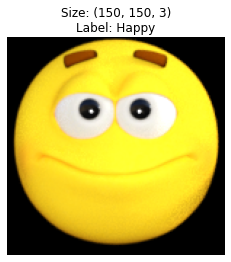

In [6]:
# get one batch
for (batch_images, batch_labesl) in test_generator:
    # get one sample
    image = batch_images[0]
    label = labels[int(batch_labesl[0])]

    # plot
    plt.figure()
    plt.title(f"Size: {image.shape}\nLabel: {label}")
    plt.axis('off')
    plt.imshow(image.squeeze())
    plt.show()

    break

# reset
test_generator.reset()

## Model

**Note**
- The problem is binary classification.
- Use `'sigmoid'` activation function in the output layer.
- Use `'binary_crossentropy'` loss.

In [7]:
# input layer
input_tensor = Input(shape=[150, 150, 3])

# convolution layers
x = Conv2D(64, 3, activation='relu')(input_tensor)
x = MaxPool2D()(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPool2D()(x)
x = Conv2D(32, 3, activation='relu')(x)
x = MaxPool2D()(x)

# fully-connected layers
x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dense(128, activation='relu')(x)

# output layer with 'sigmoid' activation function
output_tensor = Dense(1, activation='sigmoid')(x)

# model
model = tf.keras.Model(input_tensor, output_tensor)

# compile with 'binary_crossentropy' loss
model.compile(
    optimizer=Adam(),
    loss='binary_crossentropy',
    metrics=['acc']
)

# model summary
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        18464     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 32)        9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 32)        0     

## Callback

- You can use [pre-defined callbacks](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks).
- Or, you can define custom callback to have more control over what happens during the training or prediction.
[See more](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/Callback).

**Note**:
- Use `log.get()` to get desired metric to monitor.
- The parameter name in `log.get()` should match the metric defined in `model.compile()`.

In [8]:
class MonitorAccuracy(tf.keras.callbacks.Callback):
    """
    a custom class of callback
    to check accuracy after end of each epoch, and
    to stop training when a certain level of accuracy is reached
    """

    def __init__(self, stop_accuracy=0.99):
        # initiate
        super(MonitorAccuracy, self).__init__()
        self.stop_accuracy = stop_accuracy

    def on_epoch_end(self, epoch, logs=None):
        # at the end of the epoch, print loss and accuracy
        print(f"Epoch {epoch+1} - loss: {logs.get('loss'):.4f} - acc: {logs.get('acc'):.4f}")

        # if accuracy is greater than the given 'stop_accuracy':
        if logs.get('acc') > self.stop_accuracy:
            # print the termination message
            print(f"\nAccuracy reached to {self.stop_accuracy}. So, cancelling training...")
            # stop training
            self.model.stop_training = True


monitor_acc = MonitorAccuracy(0.999)

## Training

In [9]:
# train the model and save the history
hist = model.fit(
    train_generator,
    epochs=100,
    verbose=0,
    callbacks=[monitor_acc]
)

  ...
    to  
  ['...']
Epoch 1 - loss: 0.6650 - acc: 0.5000
Epoch 2 - loss: 0.9003 - acc: 0.5000
Epoch 3 - loss: 0.6540 - acc: 0.5000
Epoch 4 - loss: 0.5214 - acc: 0.9250
Epoch 5 - loss: 0.3414 - acc: 0.9750
Epoch 6 - loss: 0.2337 - acc: 0.9375
Epoch 7 - loss: 0.1641 - acc: 0.9375
Epoch 8 - loss: 0.1212 - acc: 0.9500
Epoch 9 - loss: 0.1387 - acc: 0.9375
Epoch 10 - loss: 0.1527 - acc: 0.9500
Epoch 11 - loss: 0.0666 - acc: 0.9750
Epoch 12 - loss: 0.0735 - acc: 0.9625
Epoch 13 - loss: 0.0753 - acc: 1.0000

Accuracy reached to 0.999. So, cancelling training...


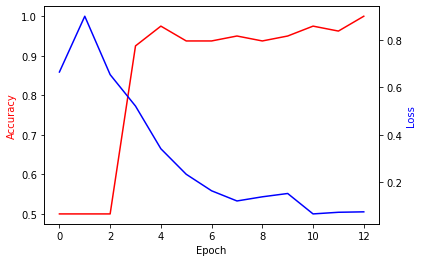

In [10]:
# plot the loss and accuracy
fig = plt.figure()
ax1 = fig.gca()

ax2 = ax1.twinx()
ax1.plot(hist.history['acc'], label='Accuracy', color='r')
ax2.plot(hist.history['loss'], label='Loss', color='b')

ax1.set_xlabel('Epoch')
ax1.set_ylabel('Accuracy', color='r')
ax2.set_ylabel('Loss', color='b')

plt.show()

## Evauation

In [11]:
# test
# NOTE: 'test_generator' uses training data, without shuffling
# ideally, you should not use training data for testing
y_pred = model.predict(test_generator)
y_pred = y_pred > 0.5

**Confusion matrix**

In [12]:
# get true test labels
y_test = test_generator.labels

# confusion matrix
conf_mat = confusion_matrix(y_test, y_pred, normalize='true')

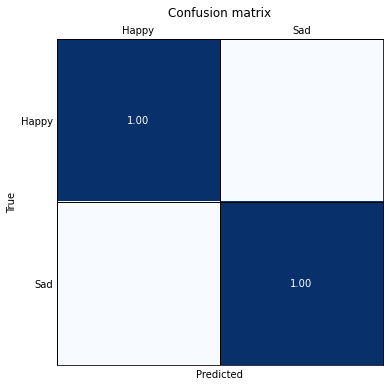

In [13]:
# figure for displaying the confusion matrix
fig = plt.figure(figsize=(6, 6))
ax = fig.gca()

# display the confution matrix
cax = ax.matshow(conf_mat, cmap='Blues')

# show the values
for (i, j), z in np.ndenumerate(conf_mat):
    text_color = 'w' if i == j else 'k'
    if z < 0.005:
        continue
    ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center', c=text_color)

# title and axis labels
plt.title('Confusion matrix')
plt.xlabel('Predicted')
plt.ylabel('True')

# show class names
plt.xticks(indices, labels)
plt.yticks(indices, labels)
ax.tick_params(axis='both', which='both', length=0)

# show grid lines
ax.set_xticks(np.arange(-.5, 2, 1), minor=True)
ax.set_yticks(np.arange(-.5, 2, 1), minor=True)
ax.grid(which='minor', color='k', linestyle='-', linewidth=1)

plt.show()

**Other metrics**

In [14]:
# calculate precision, recall, and f1 score
precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

In [15]:
# pandas data frame for storing the metrics
df = pd.DataFrame({
        'Precision': precision,
        'Recall': recall,
        'F1-score': f1
},
    index=labels
)

# calculate the mean
df.loc['(Average)'] = df.mean()

# display
df

,Precision,Recall,F1-score
Happy,1.0,1.0,1.0
Sad,1.0,1.0,1.0
(Average),1.0,1.0,1.0
